# BASE MODEL

This is the base model for the social dynamics simulation. The implementation is as follows:

The SocialDynamicsSimulation class is initialized with several parameters to deefine the network as described below:

### Constraints:

0<=alpha<=1

0<=beta<=1

gamme>0

    Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        


In [1]:
#Import required packages
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
import itertools
import scipy
import warnings
#These were depreceation errors, nothing to be concerned by. I wanted a neat page so I turned these off
warnings.filterwarnings('ignore')

### Utility vector field function.

In [2]:
def vector_plot(sim):
    graph = sim.graph
    alpha = sim.alpha
    beta = sim.beta
    gamma = sim.gamma

    #Opinion difference
    x = []
    #Weight
    y = []
    for edge in graph.edges(data=True):
        x.append(abs(graph.nodes[edge[0]]['opinion']-graph.nodes[edge[1]]['opinion']))
        y.append(edge[2]['weight'])

  
    cmap = plt.cm.viridis  # good for color blindness

    # Plot traces of how opinion and weight change over time
    for opinion, weight in [[0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]]:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    plt.plot([0, 1], [0.05, 0.05], 'k--')
    plt.axis('square')
    plt.title(f"Vector plot: Alpha: {alpha}, Beta: {beta}, Gamma:{gamma}")
    plt.show()
    print(f"AVERAGE DEGREE CONNECTIVITY \
            {np.average(list(nx.average_degree_connectivity(graph, source='in+out', target='in+out', nodes=None, weight=None).values()))}")

In [3]:
#Initialize and define the class
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

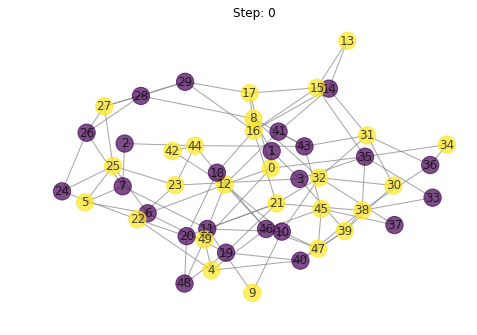

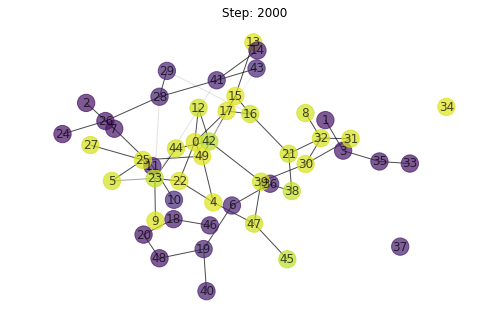

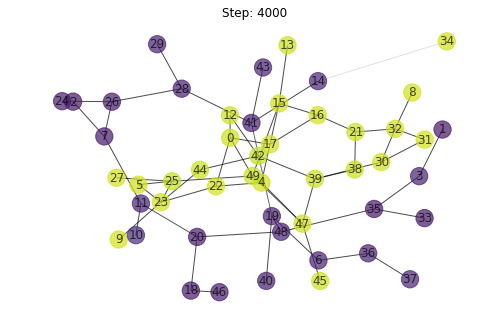

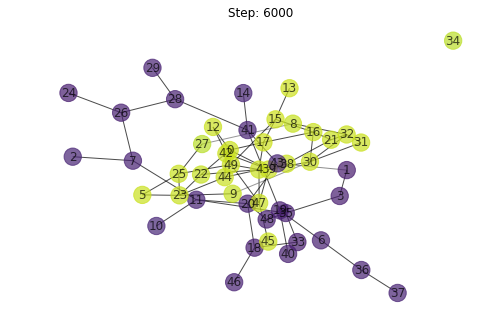

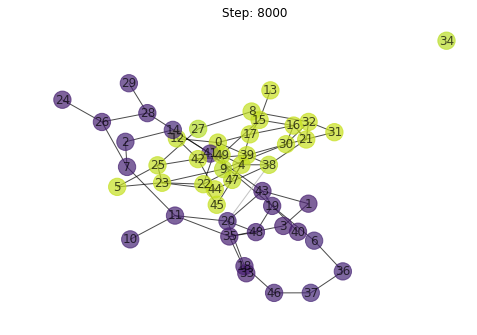

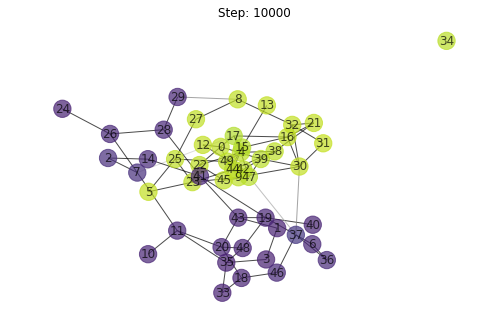

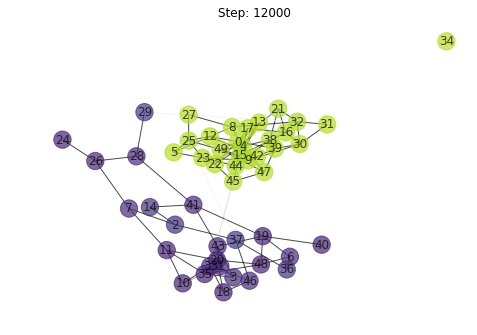

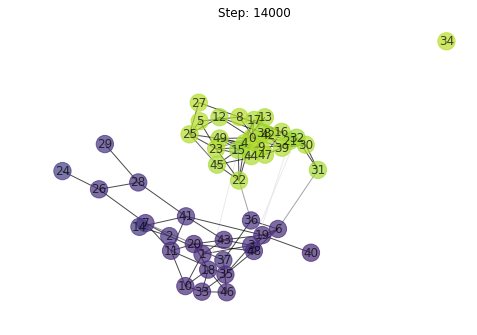

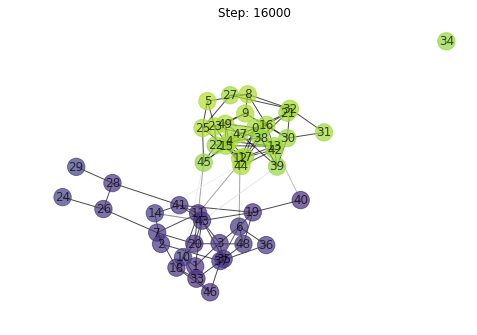

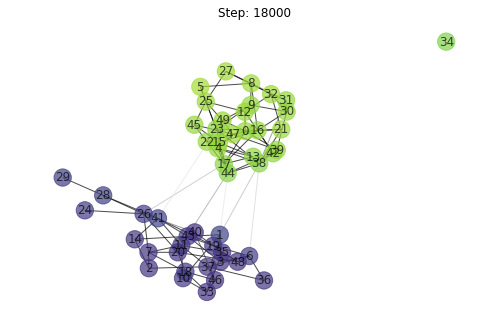

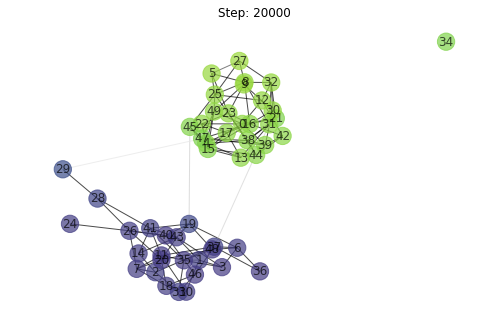

In [4]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

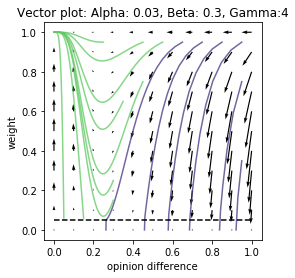

AVERAGE DEGREE CONNECTIVITY             4.921781305114639


In [5]:
vector_plot(sim)

# Proposed Modifications

## Mediation: Agree to Disagree

The first suggested modification is the inclusion of a mediator function. The idea is to dynamize the probability of changing connection. At the moment, the weight of the edges, represents the strength of our connection. These are updated by the equation:

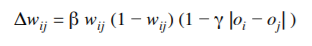

The thing is though, this can end up making a connection so weak that the connection may be terminated. My proposal is to have a conflict mediator check right before we eliminate weak connections. The mediation will depend on there being a mutual friend with a strong connection to both nodes. This means, the nodes may have many mutual friends but if all the connections are weak, then they may still end up having super weak connections. But if they have just one super strong friend between them, then they may put aside their differences and maintain a connection. The weight of this connection will depend ong the strength of connection between them and the mutual friend. I will update it by boosting the current weak connection with the average mutual friend connection strength. In this regard, even people with differences can "agree to disagree".

Thus the pseudocode for the connection removal will be as follows:

```

def mediator(my_edge):
            #Get nodes connected by the edge
            edge_nodes = get_nodes(my_edge)

            #Get node neighbors
            edge_nodes_1_neighbors = edge_nodes[1].neighbors()
            edge_nodes_2_neighbors = edge_nodes[2].neighbors()

            #Get mutual neighbors
            mutual_friends = list(set(edge_nodes_1_neighbors).intersection(edge_nodes_2_neighbors))

            #Retrieve edge strengths between mutual friends
            mediator_strength = [0] #Initiate with 0 in case there is no mutual node
            for node in mutual_friends:
                strength_between_node_and_edge_nodes = average([edge_weight(node,edge_node[1),edge_weight(node,edge_node[1)])
                mediator_strength.append(strength_between_node_and_edge_nodes)

            #Update edge strength when done
            edge+=max(mediator_strength)

if edge_weights< 0.05:
            mediator(my_edge)
            #After updating we now remove edge if the connection is still too weak after mediation.
            # Remove very weak connections
            if egde_weight< 0.05:
               graph.remove_edge(edge)

```


## Local Analysis: Mediator modification.
I found it to do the implementation step intermittently as I was describing the prescribed modification.

In the mediator case, the model will proceed such that in case two people have a connection so weak that it is about to break apart, we try and reinforce it. In this regard, we never really burn bridges. This is a utopian world for sure but in some strata of society like families, sometimes severing connections is never an option. Regardless of opinion, there always have to be a resolution. The resolution almost always entails coming to a middleground. In this case, we force a connection to be enforced. The evolution of the opinions will be premised by the fact that the connection is now relatively strong and since the opinion evolves such that people tend to become more like those they are close to, this system will end up establishing a common belief and opinion. In an aim to forster peace, people in this system go for establishing a middle ground over time. Nonetheless, we can sense the aspect of compromise at the begining where stratification is happening based on opinion but over time, the system becomes unified. This is a reflection of the human belief that time heals everything especially if we chose to hold on.

Keeping with this family mentality, lets adjust our parameters:

### alpha:
*The rate of opinion change, within a family, things change quite quickly to tolerate each other. I thus increased this rate to 0.1*

### beta: 
*The rate at which weights change in response to differing  opinions. We expect people to dislike each other of course, but the change is never so drastic that it kills this connection. In this regard, we expect a lower value of beta. I went for 0.1*

### gamma:
*The pickiness of a node. A node never gets to chose Its family. In this regard, one has to be more tolerant of the opinions of their family. To increase the tolerance, we must reduce the point at which a node becomes bothered enough to break a connection. Gamme will thus be increased to 6*


In [6]:
#TODO: Mediation
#Initialize and define the class
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.1, beta=0.1, gamma=6):
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
    
    def mediator(self, edge):
        #Get the nodes from the edge
        node_1, node_2 = edge
        #Get neighbors
        node_1_neighbors = list(self.graph.neighbors(node_1))
        node_2_neighbors = list(self.graph.neighbors(node_2))
        #Get mutual friends
        mutual_friends = list(set(node_1_neighbors).intersection(node_2_neighbors))
        #Initiate mediator strength
        mediators_strength = [0]
        for node in mutual_friends:
            #Get strength between the nodes
            edge1, edge2 = (node,node_1),(node,node_2)
            mediator_strength = np.average([self.graph.edges[edge1]['weight'],self.graph.edges[edge2]['weight']])
            mediators_strength.append(mediator_strength)
            
        #Reinforce relationship: Now we update the graph edge with the new strength being the mediator's influence
        self.graph.edges[edge]['weight'] = min(1,self.graph.edges[edge]['weight']+max(mediators_strength))
        #Now the next step is to check if the strength is still too low. See this in the update checker
        
    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.mediator(edge)
                #If the strength after mediation is still too low, remove the edge
                if self.graph.edges[edge]['weight'] < 0.05:
                    self.graph.remove_edge(*edge)
        self.step += 1

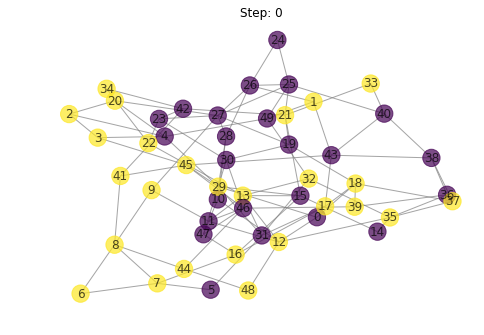

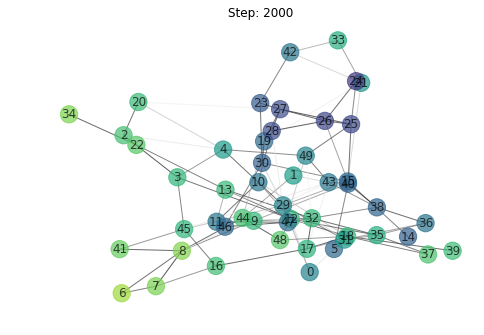

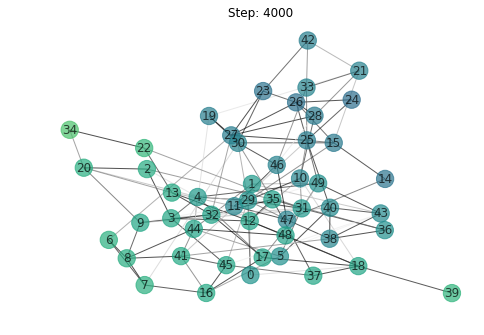

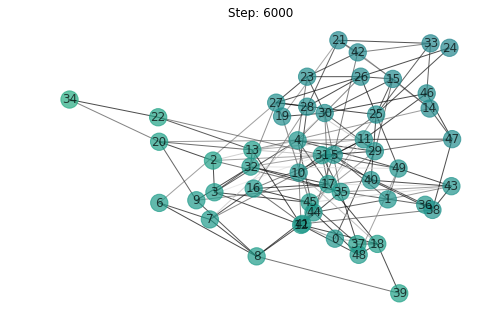

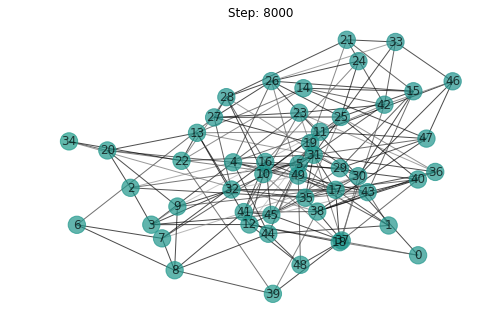

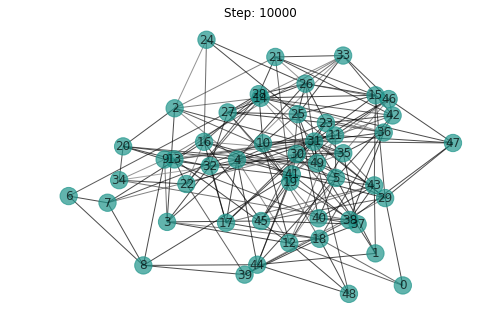

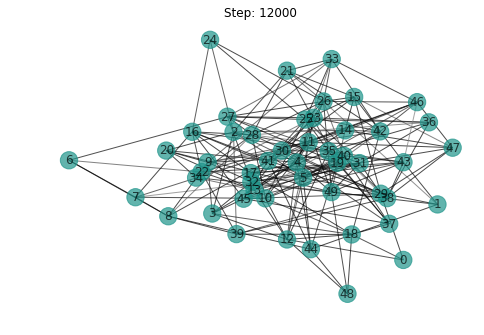

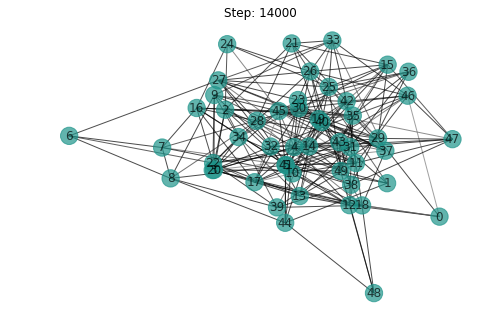

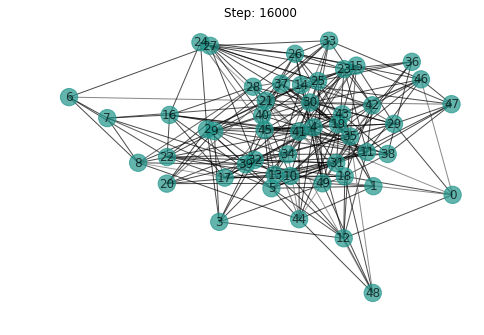

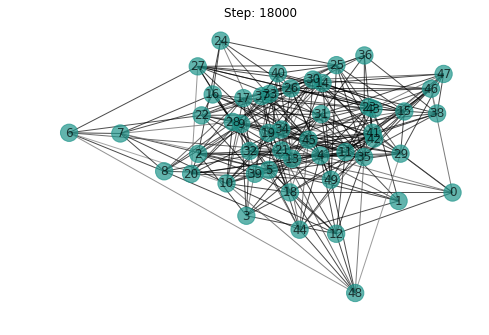

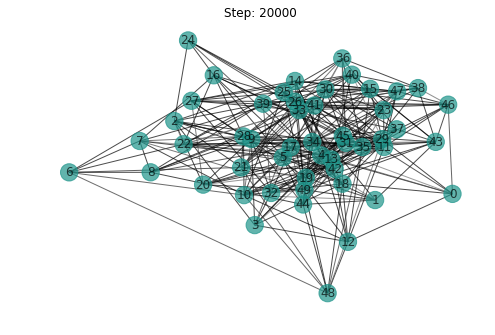

In [7]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

As expected, over time,there is a relative state of similarity. There is no clustering. The family structure is such that no one gets isolated regardless of their beliefs and we see how relationships get mended over timel. At the end, we have a homogenous network with very strong connections between edges. The degree of connectivity is higher than the base model since our model is tuned to maintain connections. See the vector plot below for a discussion on what it means and the average connectivity value.

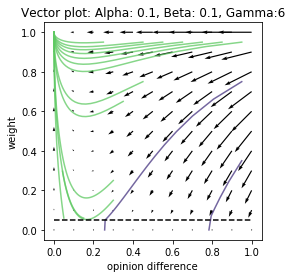

AVERAGE DEGREE CONNECTIVITY             12.315803718698454


In [8]:
vector_plot(sim)

We have only green traces here and theytend towards a weight of 1. The opinion difference in this model is almoost compltely minimized in this model which corresponds to the intuition we had when creating it in the first place. In this system, we see how connectivity is what matters most. The closest people are family members and they have a weight value of about 1. Generally, the system is tending towards convergence with regard to opinion difference. We also see how the connections are tending towards 1 s. Even our purple traces are tending towards a weight value of and minimization of tha opinion differences. This is a reflection of the behavior we expected of the system. Mediators will always find a way to establish peace regardless of opinions.

# New relationships

With this one, we will add new edges based on there being a connecting factor. Just like the mediation above, the new connection will be determined by there being mutual friends. The idea is, if nodes have say 3 or more mutual friends, then it only makes sense they have a connection. The strength of the edge should depend on the number of mutual friends edges have. As such, people with many mutual friends are more likely to form stronger connections. My thought process is not to take opinion into account first when creating these and let opinions be updated later on their own. This will allow for people with stark differences to form connections. They can dislike each other later and weaken their connections. In a way, this reflects how friendships start. They start off at a mild level, mostly through mutual friends and depending on the opinion levels, they evolve.

This is a pseudocode for the new_relationships function I have implemented.

```
def new_relationships():
    #Create copy so that we update based on the current state and not the updated state of the graph
    copy_of_graph = graph
    #This is a bit of a computationally intense process.
    #We optimize it by only creating connection with nodes with which there was no connection.
    #We can optimize it further by limiting the depth of search
    #(The further the depth, the less likely there will be mutual friends).
    #Given the size of the graph, we can afford to be exhaustive and scan the whole graph for these.
    for node in graph:
        #Run through the rest of the nodes
        for other_node in graph:
            #Only go through if there is not existing connection
            if not connected(node, other_node):
                mutual_neighbors = mutual(node, other_node)
                total_neighbors = sum(len(neighbors(node)),len(neigbors(other_node)) )
                #New_relationship in the graph copy. The weight has a base of say 0.05.
                #It is strengthened by the number of common friends
                if len(mutual_neighbors)>=1:
                    #Weight: if all our friends are friends, then we will have a super strong connection.
                    #The new relationship strength is dependent on the proportion of common friends we have
                    weight = min(1,  0.05+((num_mutual_neighbors/total_neighbors)*0.05))
                    copy_of_graph.add_edge(node, other_node, weight)
                
                
    #Only after we complete this do we replace the graph with Its copy
                
                
    
```
## Local Analysis: New Relationships.

The strategy I took with this one entails that we expect many relationships to spawn. I think social media might be a good reference when making this. We make and break relationships very often online. Our tolerance to people of different opinion too is usually very low and we tend to be very picky about who we can tolerate populating our feed. As such, I did the following parametric adjustments to capture this:

### alpha:
*The rate of opinion change, People rarely change their stance online. They tend to fight a lot but at the end, they just troll each other and then move on to the next meme and argue about it. I thus expect a very low rate of opinion change. I will set this value to 0.01.*

### beta: 
*The rate at which weights change in response to differing  opinions. On social media, breaking connections is as easy as blocking or unfriending people. The weights as such imply a very volatile network.  As such, the beta rate will be set to a value that is higher than usual. I used 0.9 in this case.*

### gamma:
*The pickiness of a node. People are never tolerant of a diversity of opinion on social media. In this regard, their tolerance to difference will be quite low. I will set this value to 10 such that any small difference in opinion 0.1 or larger spawns a change in weight*


In [9]:
#TODO: new_relationship
#Initialize and define the class
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.01, beta=0.9, gamma=10):
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0
    
    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
        
    #Utility function to check if nodes are connected
    def nodes_connected(self,node1, node2):
        return node1 in self.graph.neighbors(node2)
    
    def new_relationships(self, neighbors_limit =2):
        #Create a sandbox copy of the graph
        graph_copy = self.graph
        #Iterate through graph nodes
        #Get_all_nodes
        nodes = list(self.graph.nodes(data=False))
        #Run through all nodes.
        for node in nodes:
            #Get Node neighbors
            node_neighbors = list(self.graph.neighbors(node))
            #Now check for the rest of the nodes
            other_nodes = nodes
            other_nodes.remove(node)
            for other_node in other_nodes:
                #If our current node is not already connected to the other node, proceed
                if not self.nodes_connected(node, other_node):
                    #Get the number of common neighbors
                    num_mutual_neighbors = len(list(nx.common_neighbors(self.graph, node, other_node)))
                    total_neighbors = sum([len(list(self.graph.neighbors(node))),
                                           len(list(self.graph.neighbors(other_node)))])
                    #If the number of mutual neighbors is greater than our set limit, we proceed
                    if num_mutual_neighbors>=neighbors_limit:
                        #We then calculate a weight for the new relationship
                        #We start at a bare minimum reinforced based on number of friends.
                        #The bare minimum is the same number as that we check for to remove edges, 0.05
                        new_weight = min(1, 0.05+((num_mutual_neighbors/total_neighbors)*0.05))
                        #Update Sandbox Graph
                        graph_copy.add_edge(node,other_node, weight=new_weight)
                        
            #After everything, now replace the graph with the sandbox copy
            self.graph = graph_copy
            #The next step is to enforce this update. See the start of the update function
            
    def update(self):
        #Enforce new relationships first
        self.new_relationships()
        
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

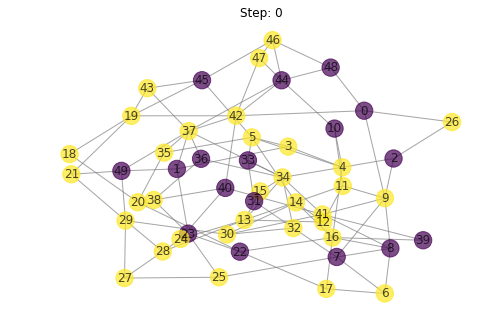

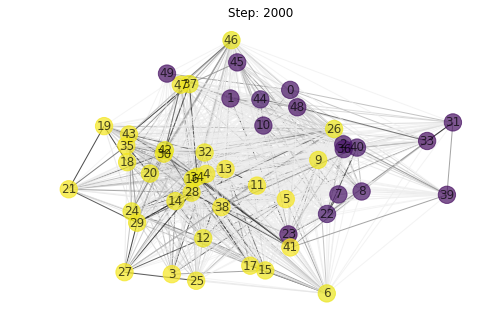

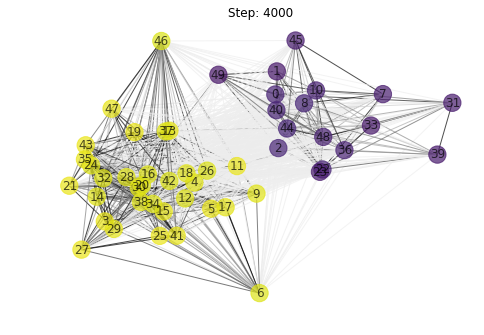

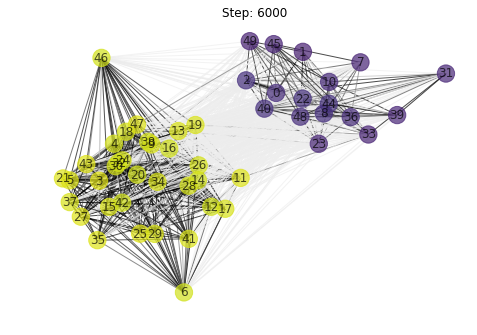

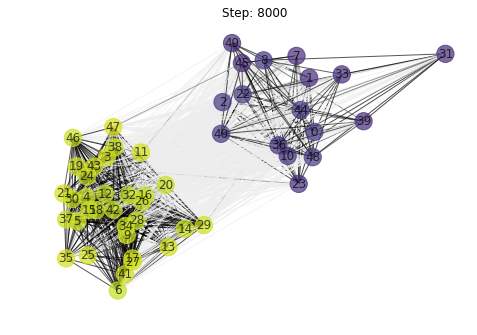

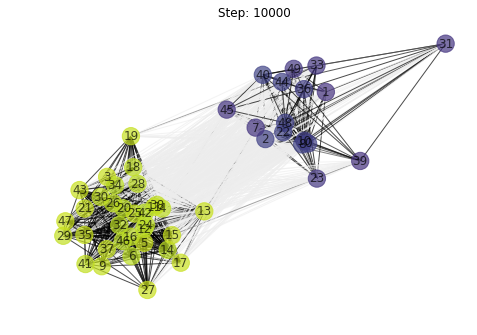

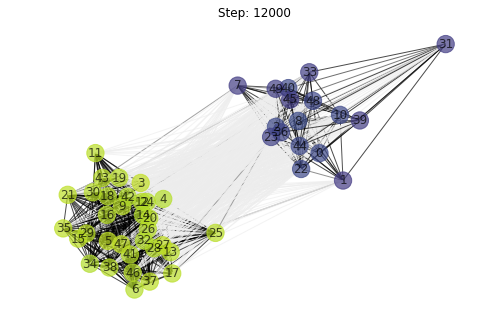

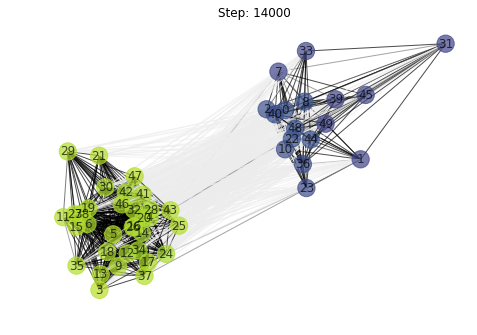

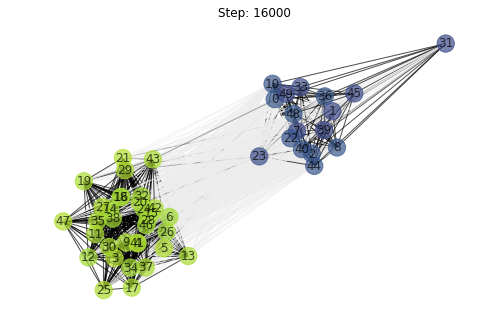

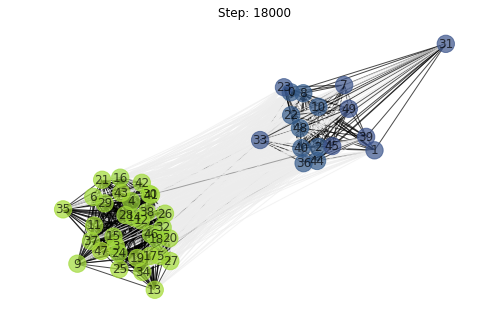

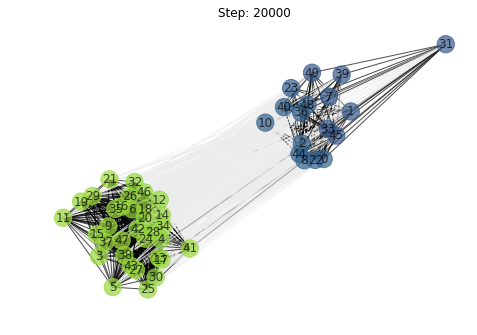

In [10]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()
    

This one here is more interesting. We end up with very close clusters. Going with the social media analogy, we see this behavior online where people tend to make facebook groups and like such groups in huge numbers based on their interests. Connectivity within these groups is incredibly strong. This is because people in the group tend to have common interests.

Nonetheless, connectivity between the two clusters is not 100% servered. There are connections but based on their shades, we see that they are weaker than the intracluster ones. These connections are bcause on facebook, the small world degree of connectivity is about 3.5 to 4 which means almost everyone is connected to everyone albeit indirectly. The average shortest path to most people in the world through our friends list would thus be about 4 given this. Our model reflects this aspect People also tend to be connected to a lot of people and this is what facilitates the interconnectivity. It is why as we see in the plot and average degree connectivity log below,  the number of connections most of the nodes have is almost the whole network. We have stratification but everyone is connected to eachother nonetheless.

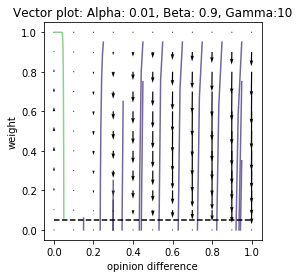

AVERAGE DEGREE CONNECTIVITY             44.708275492156865


In [11]:
vector_plot(sim)

This vector plot shows us how opinion difference in this system matters a lot. In this system, most connections are tending towards termination. This is compensated by the high rate of relationship regeneration buut we see by the line traceshow many differences in opinion are going down and for those with whom there is little difference, they are converging towars 1 quite quickly. The green lines are responsible for the super strong intra cluster connections. The purple ones are the very weak inter cluster ones. The size of the vectors illustrates the pace of weight change. Big opinion differences lead to connections being terminated even faster. 

# FURTHER NOTES

I did not change the graph used because the watts_strogatz_graph made sense to use. I expected clusturing behaviour in this system and a lot of interconnectivity between nodes in a common cluster. I aimed to capture the small world phenomenon. I also wanted to have the posibility of hubs which are nodes with verys trong opinions. These will influence the other nodes around them. In a family structure, this is usually a parents. In social media, this is usally about some politician or influencer but in this case, nobody is mending connections that are broken hence why clustering is seen. In the Mediation model, connections are mended fast and as such, clustering does not occur.

### When clustering happens:

This was observed especially in the new relationships models. This happens when the sensitivity of the weights to opinion difference is increases. Connections tend to be servered and then these individuals will converge towards those of similar opinions. In the family case, we see how the weights are not as sensitive to opinion differences as these are mended fast.

### Patterns in real life:

I have made use of analogies from real life that tend to showcase the properties of the models. Families tend to converge to similar opinions and they tend to be united through the hardest of times thus the connectivity is strong and the opinions are similar. Clusturing almost never happens.

The social media analogy for the new relationships model reflects how people converge on common group and have almost family like connections where there is strong intra cluster connectivity but weak inter cluster connectivity. People are always connected online but the strength of the connection depends on the cluster they belong to.

COLAB LINK: 